In [1]:
'''
    Importing the data from the ROOT files
    All root data files can be obtained through the open data 
    program from the ATLAS collaboration. 
    They can be found here:
        http://opendata.atlas.cern/samples-13tev/
    All data files are in root format and require 
    the installation of ROOT's python interface. 
    ROOT is a CERN C++ Library which can be found here:
        https://root.cern.ch/
'''

import numpy as np
import ROOT
from ROOT import TMath
from DataLoader import LoadDataAndProcess

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")
ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")
WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")
data1 = ROOT.TFile.Open("data_A.GamGam.root")
data2 = ROOT.TFile.Open("data_B.GamGam.root")
data3 = ROOT.TFile.Open("data_C.GamGam.root")
data4 = ROOT.TFile.Open("data_D.GamGam.root")

# Channel Dictionary
Channels = {"ttH":ttH.Get("mini"),
            "ggH":ggH.Get("mini"),
            "WWH":WWH.Get("mini"), 
            'data1':data1.Get('mini'), 
            'data2':data2.Get('mini'),
            'data3':data3.Get('mini'),
            'data4':data4.Get('mini')
        }

# Loading the data into the dicrtionaries
for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

# This outputs refer to the targets for the Neural Network
# Initially all signal channels are differentiated from each other
OutputMap = {'ttH':[1,0,0,0],'ggH':[0,1,0,0],'WWH':[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}


# Sort Photons by Energy
def SortAndFlatten(Particles, SortFunction):
    datapoint = []
    Particles.sort(key = SortFunction)
    for particle in Particles:
        datapoint.append(particle.E())
        datapoint.append(particle.Px())
        datapoint.append(particle.Py())
        datapoint.append(particle.Pz())
    return datapoint

# Compute invariant mass and sort by energy
def SortFlattenAndInvariantMass(Particles, SortFunction):
    datapoint = []
    Particles.sort(key = SortFunction)
    datapoint.append(np.sqrt(2*(Particles[0].E()**2-Particles[0].Px()**2-Particles[0].Py()**2-Particles[0].Pz()**2)))
    for particle in Particles:
        datapoint.append(particle.Px())
        datapoint.append(particle.Py())
        datapoint.append(particle.Pz())
    return datapoint

'''
    Loading both datasets from the ROOT files into 
    we also apply a sorting to both datasets

'''

UnprocessedLambda  = lambda Photons : SortAndFlatten( Photons, lambda Photon : -Photon.E() )
UnprocessedDataset = LoadDataAndProcess(Channels, OutputMap, UnprocessedLambda, 50000 )

PreprocessedLambda  = lambda Photons : SortFlattenAndInvariantMass(Photons, lambda Photon : -Photon.E() )
PreprocessedDataset = LoadDataAndProcess(Channels, OutputMap, PreprocessedLambda, 50000)

Welcome to JupyROOT 6.24/02
Channel: ttH has 576491 entries
Channel: ggH has 1054711 entries
Channel: WWH has 497468 entries
Channel: data1 has 430344 entries
Channel: data2 has 1528717 entries
Channel: data3 has 2237187 entries
Channel: data4 has 3602176 entries
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data2
Processing Channel  data3
Processing Channel  data4
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data2
Processing Channel  data3
Processing Channel  data4


In [2]:
from Model import Model

UnprocessedModel = Model("Uprocessed","./Unprocessed",UnprocessedDataset)
UnprocessedModel.loadFromPath("./Unprocessed")
UnprocessedModel.analyze()

PreprocessedModel = Model("Preprocessed","./Preprocessed",PreprocessedDataset)
PreprocessedModel.loadFromPath("./Preprocessed")
PreprocessedModel.analyze()

Uprocessed  efficiency : 60.51593253849209 %
Preprocessed  efficiency : 59.36052707517278 %


2022-09-16 16:57:13.816992: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-16 16:57:13.817022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Amelia
2022-09-16 16:57:13.817030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Amelia
2022-09-16 16:57:13.817092: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-09-16 16:57:13.817118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-09-16 16:57:13.817124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.85.2
2022-09-16 16:57:13.817939: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

In [44]:
# Histrograms 

from Util import *
import matplotlib.pyplot as plt

Higgs_Unprocessed  = [] 
Background_Unprocessed  = []

UnprocessedPredition = UnprocessedModel.model.predict(UnprocessedDataset[:,:-4])

for i in range(len(UnprocessedDataset)):
    if(UnprocessedDataset[i][-1]==1):
        Background_Unprocessed.append(prob(UnprocessedPredition[i]))
    else:
        Higgs_Unprocessed.append(prob(UnprocessedPredition[i]))

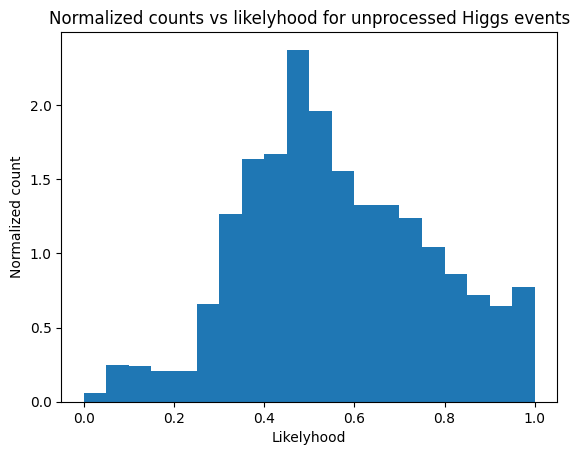

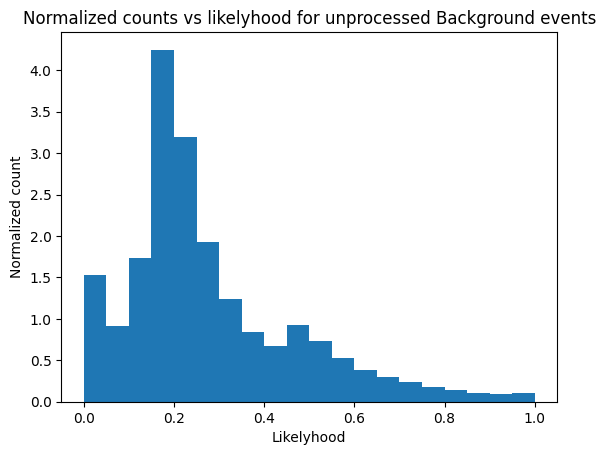

In [47]:
plt.clf()
plt.title('Normalized counts vs likelyhood for unprocessed Higgs events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Higgs_Unprocessed, density = True, bins=[i/20 for i in range(21)])
plt.savefig('Higgs_Unprocessed_Likelyhood')
plt.show()   

plt.clf()
plt.title('Normalized counts vs likelyhood for unprocessed Background events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Background_Unprocessed, density = True, bins=[i/20 for i in range(21)])
plt.savefig('Background_Unprocessed_Likelyhood')
plt.show()

In [42]:
Higgs_Preprocessed  = [] 
Background_Preprocessed  = []

PreprocessedPredition = PreprocessedModel.model.predict(PreprocessedDataset[:,:-4])

for i in range(len(PreprocessedDataset)):
    if(PreprocessedDataset[i][-1]==1):
        Background_Preprocessed.append(prob(PreprocessedPredition[i]))
    else:
        Higgs_Preprocessed.append(prob(PreprocessedPredition[i]))

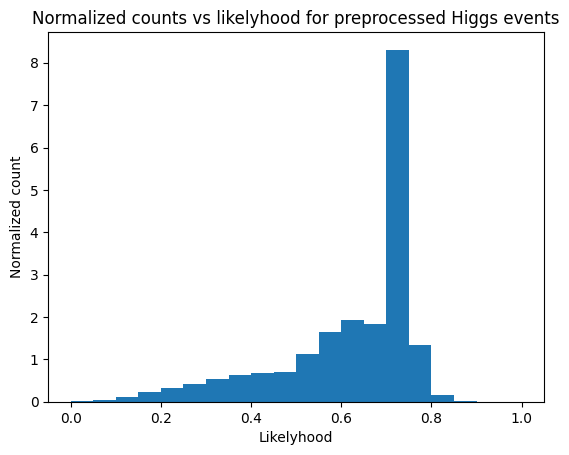

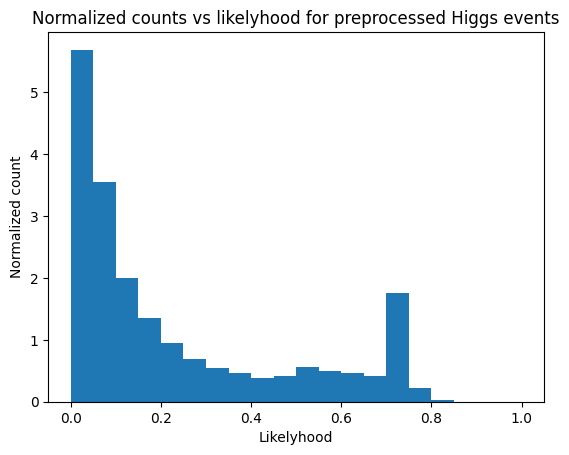

In [48]:
plt.clf()
plt.title('Normalized counts vs likelyhood for preprocessed Higgs events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Higgs_Preprocessed, density = True, bins=[i/20 for i in range(21)])
plt.savefig('Higgs_Preprocessed_Likelyhood')
plt.show()

plt.clf()
plt.title('Normalized counts vs likelyhood for preprocessed Higgs events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Background_Preprocessed, density = True, bins=[i/20 for i in range(21)])
plt.savefig('Higgs_Preprocessed_Likelyhood')
plt.show()